<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARMA</font></b></strong>

**Modelos de Média Móvel Auto-Regressiva (ARMA - Auto Regressive Moving Average)**

O modelo ARMA é simplesmente a fusão entre os modelos AR (p) e MA (q).
 
Os modelos AR (p) tentam explicar o momento e os efeitos médios da reversão frequentemente observados nos mercados (efeitos dos participantes do mercado).

Os modelos MA (q) tentam capturar os efeitos de choque observados em termos de ruído branco. Estes efeitos de choque podem ser considerados eventos inesperados que afetam o processo de observação, p, como ganhos repentinos, guerras, ataques, etc.

O modelo ARMA tenta capturar esses dois aspectos ao modelar séries temporais. O modelo ARMA não leva em consideração o agrupamento de volatilidade, um fenômeno empírico essencial de muitas séries temporais financeiras que discutiremos mais adiante.

Modelo ARMA(1,1) é representado como:

x(t) = a*x(t-1) + b*e(t-1) + e(t)

Onde e(t) é o ruído branco com E [e(t)] = 0

Um modelo ARMA geralmente requer menos parâmetros que um modelo AR (p) ou um modelo MA (q) individual. Ou seja, é redundante em seus parâmetros.

Criaremos um modelo ARMA neste notebook.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy           1.16.6
scipy           1.4.1
pandas          1.0.5
matplotlib      3.3.0
statsmodels     0.11.1
sklearn         0.23.1
statsmodels.api 0.11.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

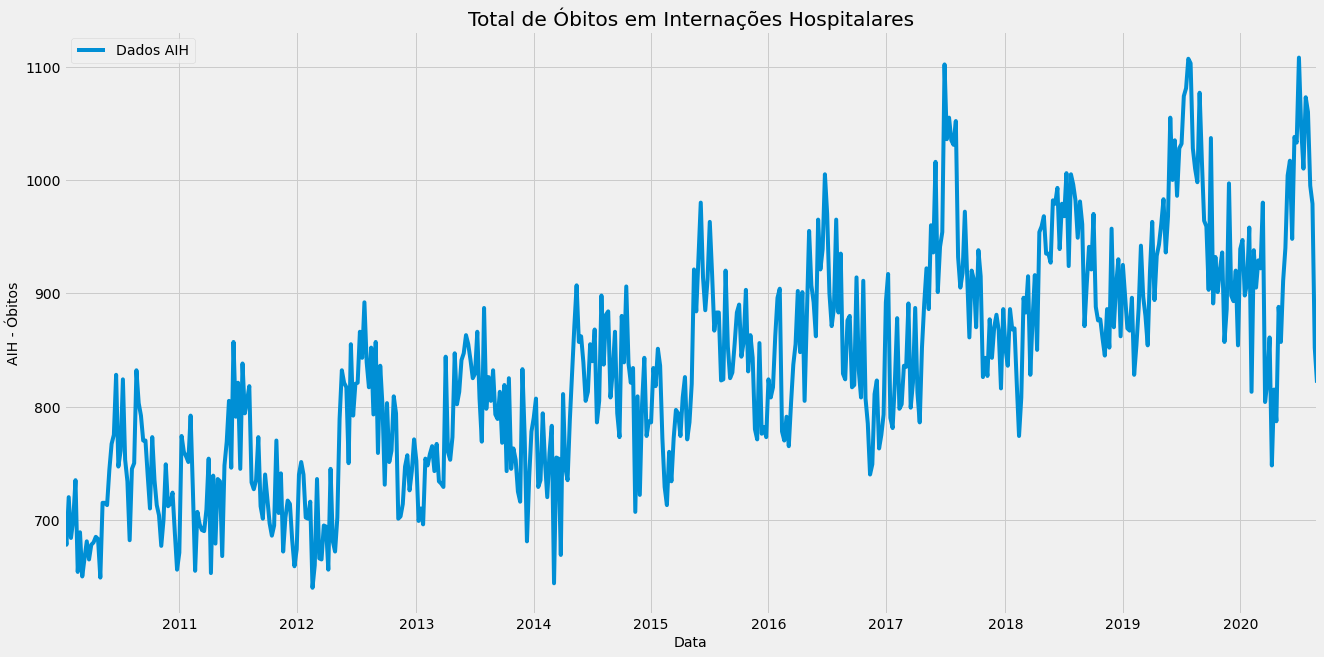

In [7]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [9]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARMA

Dada uma série temporal de dados Xt, o modelo ARMA é uma ferramenta para entender e, talvez, prever valores futuros nesta série. A parte AR envolve a regressão da variável com seus próprios valores defasados (isto é, passados). A parte MA envolve modelar o termo de erro como uma combinação linear de termos de erro que ocorrem contemporaneamente e em vários momentos no passado. O modelo é geralmente chamado de modelo ARMA (p, q), em que p é a ordem da parte AR e q é a ordem da parte MA.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html

In [56]:
# Cria o modelo
modelo_arma = ARMA(treino, order = (12, 9))

In [57]:
# Treina o modelo
modelo_arma_fit = modelo_arma.fit(method = 'mle', disp = False)

In [58]:
# Sumário do modelo
modelo_arma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               QT_INTER   No. Observations:                  417
Model:                    ARMA(12, 9)   Log Likelihood               -2156.965
Method:                           mle   S.D. of innovations             41.793
Date:                Wed, 25 Nov 2020   AIC                           4359.931
Time:                        16:49:13   BIC                           4452.692
Sample:                    01-10-2010   HQIC                          4396.605
                         - 12-31-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             799.0455     61.292     13.037      0.000     678.916     919.175
ar.L1.QT_INTER      0.1090      0.064      1.712      0.087      -0.016       0.234
ar.L2.QT_INTER      1.4796      0.006    242.707      0.000       1.468       1.492
ar.L3.QT_INTER      0.2693      0.056      4.787      0.000       0.159       0.380
ar.L4.QT_INTER     -0.3361      0.008    -41.375      0.000      -0.352      -0.320
ar.L5.QT_INTER     -0.2417      0.033     -7.418      0.000      -0.306      -0.178
ar.L6.QT_INTER     -0.6937        nan        nan        nan         nan         nan
ar.L7.QT_INTER     -0.9007      0.025    -36.543      0.000      -0.949      -0.852
ar.L8.QT_INTER      0.8665      0.016     54.472      0.000       0.835       0.898
ar.L9.QT_INTER      1.0558        nan        nan        nan         nan         nan
ar.L10.QT_INTER    -0.2458        nan        nan        nan         nan         nan
ar.L11.QT_INTER    -0.2660        nan        nan        nan         nan         nan
ar.L12.QT_INTER    -0.0976      0.013     -7.275      0.000      -0.124      -0.071
ma.L1.QT_INTER      0.3601      0.052      6.892      0.000       0.258       0.462
ma.L2.QT_INTER     -1.1737      0.026    -44.476      0.000      -1.225      -1.122
ma.L3.QT_INTER     -0.5707      0.093     -6.123      0.000      -0.753      -0.388
ma.L4.QT_INTER     -0.0130      0.030     -0.431      0.666      -0.072       0.046
ma.L5.QT_INTER     -0.0077      0.029     -0.262      0.793      -0.066       0.050
ma.L6.QT_INTER      0.5680      0.060      9.451      0.000       0.450       0.686
ma.L7.QT_INTER      1.2078      0.086     14.121      0.000       1.040       1.375
ma.L8.QT_INTER     -0.3217      0.032    -10.059      0.000      -0.384      -0.259
ma.L9.QT_INTER     -0.9678      0.062    -15.568      0.000      -1.090      -0.846
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.1212           -0.9926j            1.0000           -0.2307
AR.2             0.1212           +0.9926j            1.0000            0.2307
AR.3             0.9588           -0.3796j            1.0312           -0.0600
AR.4             0.9588           +0.3796j            1.0312            0.0600
AR.5             1.0021           -0.0000j            1.0021           -0.0000
AR.6             1.1713           -0.0000j            1.1713           -0.0000
AR.7            -0.7396           -0.7210j            1.0329           -0.3770
AR.8            -0.7396           +0.7210j            1.0329            0.3770
AR.9            -1.0479           -0.0545j            1.0493           -0.4917
AR.10           -1.0479           +0.0545j            1.0493            0.4917
AR.11           -1.7416           -

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

In [63]:
# Previsões com o modelo
arma_predict = modelo_arma_fit.predict(start = pd.to_datetime('2018-01-01'), 
                                       end = pd.to_datetime('2020-09-01'),
                                       dynamic = False)

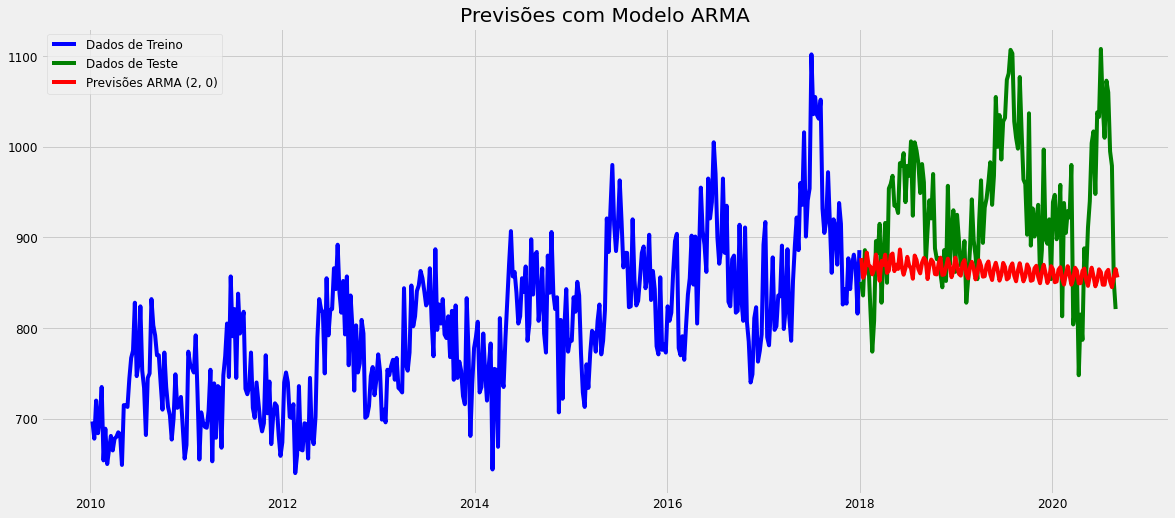

In [64]:
# Plot
rcParams['figure.figsize'] = 18, 8
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arma_predict, label = 'Previsões ARMA (2, 0)', color = 'red')
plt.title('Previsões com Modelo ARMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

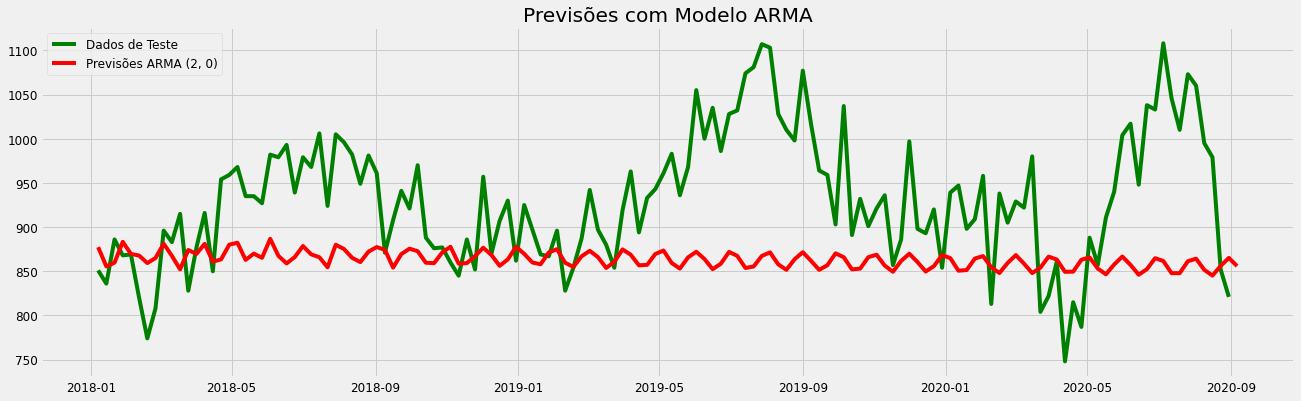

In [65]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arma_predict, label = 'Previsões ARMA (2, 0)', color = 'red')
plt.title('Previsões com Modelo ARMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [66]:
# Avaliando a performance com dados de teste 
arma_results = performance(teste, arma_predict)

MSE das previsões é 10017.1755
RMSE das previsões é 100.0858
MAPE das previsões é 8.2084


Vamos executar alguns diagnósticos para avaliar o modelo.

Começamos criando uma função com os Plots ACF e PACF, além dos resíduos.

In [46]:
# Função
def tsplot(y, lags = None, figsize = (12, 8), style = 'bmh'):
    
    # Se a série não for do tipo pd.Series, fazemos a conversão
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Criamos os plots
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Plots Para Análise de Séries Temporais')
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.05)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.05)
        sm.qqplot(y, line = 's', ax = qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)

        plt.tight_layout()
    return

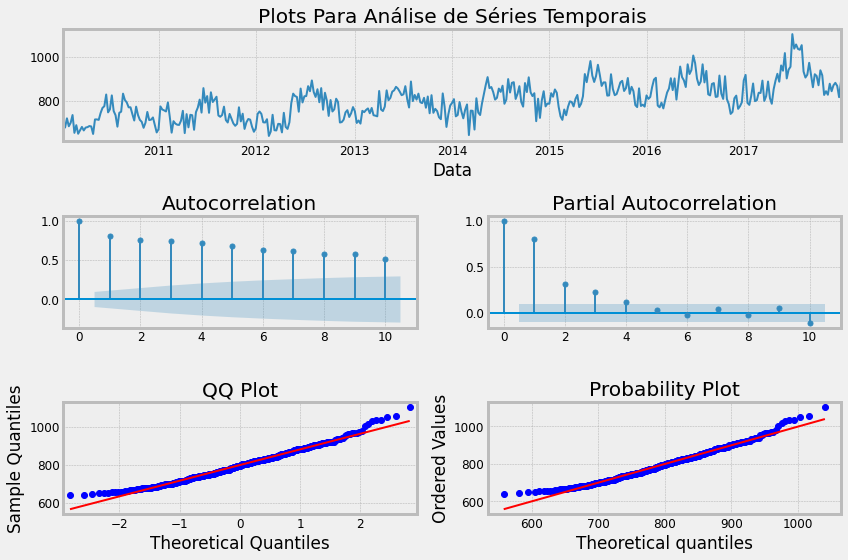

In [21]:
# Executa a função com dados de treino
tsplot(treino, lags = 10)

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [22]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arma_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.26619207  -  Os resíduos parecem normalmente distribuídos.


In [23]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arma_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [2.45806149e-05]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, um modelo ARMA (1,0) não fornece um bom ajuste do modelo.

Ajustes dos valores de p e q

Para ajustar os dados a um modelo ARMA, usamos o Akaike Information Criterion (AIC) em um subconjunto de valores para p, q para encontrar o modelo com o mínimo AIC e, em seguida, aplicamos o teste de Ljung-Box para determinar se um bom ajuste foi alcançado para valores particulares de p, q. Se o valor-p do teste for maior que a significância requerida, podemos concluir que os resíduos são independentes e ruído branco.

In [24]:
# Vamos tentar encontrar os melhores valores de p e q
# O AIC deve ser o menor possível

warnings.simplefilter("ignore")

# Valores iniciais
melhor_aic = np.inf 
melhor_order = None
melhor_modelo = None

# Valores para testar a melhor combinação order = (i, j)
valores_para_order = [1, 2, 3, 4, 5]

# Loop
for i in valores_para_order:
    for j in valores_para_order:
        try:
            tmp_mdl = ARMA(treino, order = (i, j)).fit(disp = False)
            tmp_aic = tmp_mdl.aic
            if tmp_aic < melhor_aic:
                melhor_aic = tmp_aic
                melhor_order = (i, j)
                melhor_modelo = tmp_mdl
        except: continue

# Print
print('\nMelhor Valor de AIC: %6.2f | order: %s'%(melhor_aic, melhor_order))
print('\nMelhor Modelo:', melhor_modelo.summary())


Melhor Valor de AIC: 4360.74 | order: (3, 3)

Melhor Modelo:                               ARMA Model Results                              
Dep. Variable:               QT_INTER   No. Observations:                  417
Model:                     ARMA(3, 3)   Log Likelihood               -2172.369
Method:                       css-mle   S.D. of innovations             44.098
Date:                Wed, 25 Nov 2020   AIC                           4360.738
Time:                        16:37:55   BIC                           4393.003
Sample:                    01-10-2010   HQIC                          4373.494
                         - 12-31-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            796.6746     25.334     31.447      0.000     747.021     846.328
ar.L1.QT_INTER     1.2044      0.016     75.369      0.00

Reduziu o erro do nosso modelo. 

RMSE:

modelo 11_modelo 12_modelo 13_modelo 14_modelo 15

_86.177___ 76.6730___149.2452___79.8950___100,0858

As mensagens de warning acima indicam que para algumas combinações de order (i, j) o modelo não consegue nem mesmo convergir. Por fim, a melhor combinação foi a que escolhemos no início e que apresenta a melhor performance: order: (5, 5).

Será que conseguimos fazer melhor do que isso? Você não vi nada ainda! Além do Modelo ARMA, confira os modelos que vamos criar nas próximas aulas:

- Modelo ARIMA
- Modelo SARIMA
- Modelo Triple Exponential Smoothing

- Modelo LSTM (Deep Learning)
- Modelo Stacked LSTM (Deep Learning)
- Modelo Bidirectional LSTM (Deep Learning)
- Modelo Convolutional Neural Network (Deep Learning)

Estudaremos ainda como usar Grid Search para encontrar os melhores valores dos parâmetros p, d e q.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim